# <center> NMF based Faces Representation </center>

We will use the <b>ORL database</b>, available to anyone on <a href="http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html"> AT&Tâ€™s web site</a>. This database contains images showing the faces of 40 people. Each one of them was photographed 10 times. These photos are stored as images in grey levels with 112x92 pixels. In our example, we constructed a <b>catalog called orlfaces</b>, comprised of the catalogs named $s_1, s_2, . . . , s_{40}$, each one of them containing the 10 images we are going to process. The data has been split in two parts train and test. For each catalog we use the first 9 photos for training and the last photo for test.

To avoid too large values, the data matrix is divided by max value present in all the images. Indeed, this division does not have any major impact on performance of the Matrix Factorization methods. The data has been split in two-parts train and test. For each catalog we use the first 9 photographs for training and the last photograph for test. However, we only use the training part for this lab. The final data matrix shape is given 10304 (pixels) x 360 (faces)

In [3]:
import numpy as np
import PIL.Image as img
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (17.0, 5.0)
matplotlib.rcParams['font.size'] = 15

%matplotlib inline
%load_ext autoreload
%autoreload 2

### Imports

### Load the training data

In [4]:
import orlfaces
trainData, trainlabels = orlfaces.loadDataTrain("../TP01/orl_faces")
trainData = trainData / np.max(trainData[:])

### Loading data and normalize it

### Display image example

In [5]:
i = np.random.randint(trainData.shape[1])
print("trainData[:, ", i, "] : label : ",  trainlabels[i])
orlfaces.showFaces(trainData[:, i])

trainData[:,  8 ] : label :  0


### Create the NMF function 

In [32]:
def NMF(V, RANK, MAX_ITER, LAMBDA):
    # NMF - Non-negative matrix factorization
    # B, W, OBJ, NUM_ITER = NMF(V, RANK, MAX_ITER, LAMBDA)
    # V         : Input data.
    # RANK      : Rank size.
    # MAX_ITER  : Maximum number of iterations (default 50).
    # LAMBDA    : Convergence step size (default 0.0001). 
    # B         : Set of basis images.
    # W         : Set of basis coefficients.
    # OBJ       : Objective function output.
    # NUM_ITER  : Number of iterations run.

    # Create initial matrices random initialization
    B = np.random.rand(V.shape[0], RANK)
    W = np.random.rand(RANK, V.shape[1])
    W /= W.sum(0)

    # Make sure W has unit sum columns! (each column should sum to one.

    # Calculate initial objective
    OBJ = computeObjective(V, B, W) 


    # Iterations
    old = -1
    NUM_ITER = MAX_ITER
    for iter_ in range(MAX_ITER):

        B = B * ((((V / (B @ W)) @ W.T)) / (np.ones((1, V.shape[1])) @ W.T))
        W = W * ((B.T @ ((V / (B @ W)))) / (B.T @ np.ones((V.shape[0], 1))))
        OBJ = computeObjective(V, B, W)
        if old != -1 and abs(old - OBJ) < LAMBDA:
            NUM_ITER = iter_
            break
        
        old = OBJ

    # Stop when the absolute value of the new objective function
    # value â€“ old objective value is smaller or equal to Lambda or
    # the max number of iterations is yield.


    return W, B, OBJ, NUM_ITER

def computeObjective(V, B, W):
    obj = np.sum(np.sum(-V * np.log(B @ W) - (B @ W)))
    
    return obj

### Compute NMF and objective function
#### The purpose of this method is to find a B and a W matrix that could give us the base matrix X thanks to the multiplication of these ones: X = B W
#### The matrix B would contain rows representing the strength of a component and image association
#### The matrix W would contain rows representing the different components used to describe the images
#### The components we obtain with the NMF method make more sense than the PCA method when we are trying to decompose faces because it is difficult to interpret the negative and positive components the PCA gives us. If we try to print the components given by the NMF we can clearly see facial features.
#### In the algorithm we also added a lambda to converge quicker.

- As seen in the lecture for the KL divergence

    - Start iteration
    $$ B = B \otimes \frac{\left(\frac{V}{BW}\right)W^T}{\mathbb{1}W^T} $$
    $$ W = W \otimes \frac{B^T\left(\frac{V}{BW}\right)}{B^T\mathbb{1}} $$

The division is elements by element.

$\otimes$ The multiplication is elements by elements

### Compute the NMF using this script

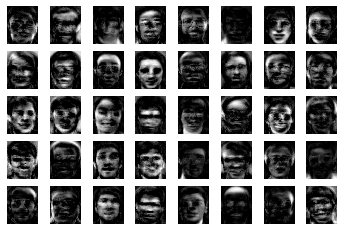

In [34]:
B, W, obj, k = NMF(trainData, 40, 500, 0.001)


for k in range(40):
    plt.subplot(5, 8, k + 1)
    orlfaces.showFaces(W[:, k])

#### We can see with the images printed that faces are linear combination of facial features

### Compare your results to the NMF predefined function in python sklearn.decomposition.NMF

In [ ]:
from sklearn.decomposition import NMF

model = NMF(n_components = 40, init='random', random_state=0, solver='mu', beta_loss='kullback-leibler', max_iter = 1000)
W1 = model.fit_transform(trainData)
B1 = model.n_components_

for k in range(40):
    plt.subplot(5, 8, k + 1)
    orlfaces.showFaces(W1[:, k])

#### We are comparing our results with the sklearn library using the KL divergence in bith cases

### Sparsity: Imposing sparsity to both B and W will generate the following updating rules.

$$ B = B \otimes \frac{\left(\frac{V}{BW}\right)W^T}{\mathbb{1}W^T + \beta} $$
$$ W = W \otimes \frac{B^T\left(\frac{V}{BW}\right)}{B^T\mathbb{1} + \alpha} $$

In [35]:
def ssnmf(V, RANK, MAX_ITER, LAMBDA, ALPHA, BETA): 
    # SSNMF - Semi Supervised Non-negative matrix factorization
    # W, H, OBJ, NUM_ITER] = SSNMF(V,RANK,MAX_ITER,LAMBDA)
    # V - Input data.
    # RANK - Rank size.
    # MAX_ITER - Maximum number of iterations (default 50).
    # LAMBDA - Convergence step size (default 0.0001).
    # ALPHA - Sparse coefficient for W.
    # BETA - Sparse coefficient for B.
    # W - Set of basis images.
    # H - Set of basis coefficients.
    # OBJ - Objective function output.
    # NUM_ITER - Number of iterations run.
    
    B = np.random.rand(V.shape[0], RANK)
    W = np.random.rand(RANK, V.shape[1])
    W /= W.sum(0)
    # Make sure W has unit sum columns! (each column should sum to one.

    # Calculate initial objective
    OBJ = computeObjective(V, B, W) 


    # Iterations
    old = -1
    NUM_ITER = MAX_ITER
    for iter_ in range(MAX_ITER):

        B = B * ((((V / (B @ W)) @ W.T)) / (np.ones((1, V.shape[1])) @ W.T) + BETA)
        W = W * ((B.T @ ((V / (B @ W)))) / (B.T @ np.ones((V.shape[0], 1))) + ALPHA)
        OBJ = computeObjective(V, B, W)
        if old != -1 and abs(old - OBJ) < LAMBDA:
            NUM_ITER = iter_
            break
        
        old = OBJ

    # Stop when the absolute value of the new objective function
    # value â€“ old objective value is smaller or equal to Lambda or
    # the max number of iterations is yield.


    return W, B, OBJ, NUM_ITER

#### Using another approache with Semi Supervised NMF

The new objective function is

In [36]:
def compute_objective(V, W, B, alpha, beta):
    obj = np.sum(np.sum(-V * np.log(W @ B) - (W @ B))) + alpha * np.sum(np.sum(B))+ beta * np.sum(np.sum(W));

    return obj

### Compute the sparse NMF for $\alpha=1$ and $\beta=100$

In [37]:
B, W, obj, k = ssnmf(trainData, 40, 500, 0.001, 0.2, 10)


for k in range(40):
    plt.subplot(5, 8, k + 1)
    orlfaces.showFaces(W[:, k])

/home/pierre-hugo/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in matmul
/home/pierre-hugo/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: overflow encountered in multiply
/home/pierre-hugo/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in matmul
/home/pierre-hugo/anaconda3/envs/my_env/lib/python3.7/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/pierre-hugo/anaconda3/envs/my_env/lib/python3.7/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/pierre-hugo/anaconda3/envs/my_env/lib/python3.7/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/pierre-hugo/ana

In [6]:
def itakura_nmf(V, RANK, MAX_ITER, LAMBDA, BETA): 
    # NMF - Non-negative matrix factorization
    # W, H, OBJ, NUM_ITER] = SSNMF(V,RANK,MAX_ITER,LAMBDA)
    # V - Input data.
    # RANK - Rank size.
    # MAX_ITER - Maximum number of iterations (default 50).
    # LAMBDA - Convergence step size (default 0.0001).
    # ALPHA - Sparse coefficient for W.
    # BETA - Sparse coefficient for B.
    # W - Set of basis images.
    # H - Set of basis coefficients.
    # OBJ - Objective function output.
    # NUM_ITER - Number of iterations run.
    
    B = np.random.rand(V.shape[0], RANK)
    W = np.random.rand(RANK, V.shape[1])
    W /= W.sum(0)
    # Make sure W has unit sum columns! (each column should sum to one.

    # Calculate initial objective
    OBJ = computeObjective(V, B, W) 


    # Iterations
    old = -1
    NUM_ITER = MAX_ITER
    for iter_ in range(MAX_ITER):
        
        B = np.multiply(B, (np.multiply((B @ W) ** (BETA - 2), V) @ W.T) / ((B @ W) ** (BETA - 1) @ W.T))
        W = np.multiply(W, (B.T @ (np.multiply((B @ W) ** (BETA - 2), V))) / (B.T @ ((B @ W) ** (BETA - 1))))
        OBJ = computeObjective(V, B, W)
        
        if old != -1 and abs(old - OBJ) < LAMBDA:
            NUM_ITER = iter_
            break
        
        old = OBJ

    # Stop when the absolute value of the new objective function
    # value â€“ old objective value is smaller or equal to Lambda or
    # the max number of iterations is yield.


    return W, B, OBJ, NUM_ITER


def computeObjective(V, B, W):
    obj = np.sum(np.sum(-V * np.log(B @ W) - (B @ W)))
    
    return obj

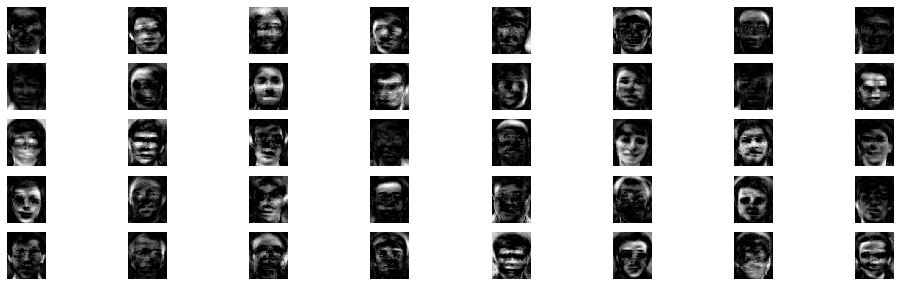

In [7]:
B, W, obj, k = itakura_nmf(trainData, 40, 500, 0.001, 0.003)


for k in range(40):
    plt.subplot(5, 8, k + 1)
    orlfaces.showFaces(W[:, k])